In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import spacy
from nltk.util import ngrams

%matplotlib inline

from nltk.corpus import stopwords

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [2]:
stop_words = stopwords.words('english')
stop_words.extend(['be','try','say','from','in','the', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [5]:
df = pd.read_csv('C:\\Users\\Shailendra Porwal\\Downloads\\combined_csv.csv',sep='\t')
df.head()

title  \
0  IMA founder has at least 14 properties worth 5...   
1  Man who invested Rs 9L in IMA dies of heart at...   
2            BBMP, cops to meet over seized vehicles   
3              More women opt for MBA course at IIMB   
4  Citizens suffer as fallen trees, branches lie ...   

                                                text  \
0  Mohammed Mansoor Khan, the elusive managing di...   
1  A 54-year-old man who had invested in the IMA ...   
2  Mayor Gangambike Mallikarjun on Thursday inspe...   
3  The Indian Institute of Management Bangalore (...   
4  Trees and branches that were brought down by r...   

                                              tag          date  
0                                      IMA fraud,   Jun 14 2019  
1                            IMA fraud,Chit fund,   Jun 14 2019  
2                           seized vehicles,BBMP,   Jun 14 2019  
3  Bengaluru,Indian Institute of Management,IIMB,   Jun 13 2019  
4             monsoon,BBMP,Rain damage,Benglauru,   Jun 13 2019

In [6]:
contraction = { 'isn\'t':'is not','aren\'t' : 'are not','wasn\'t':'was not','weren\'t':'were not',\
               'haven\'t':'have not', 'hasn\'t' :'has not','hadn\'t' :'had not','won\'t' :'will not',\
               'wouldn\'t':'would not' ,'don\'t':'do not' ,'doesn\'t':'does not','didn\'t':'did not',\
               'can\'t':'can not','couldn\'t':'could not','shouldn\'t':'should not','mightn\'t':'might not',\
               'mustn\'t':'must not'}

def exp(sent):
    new_sent=''
    words =sent.split()
    for i in words:
        if i in contraction:
            new_sent+=' '+contraction[i]
        else:
            new_sent+=' '+i
    return new_sent.strip()

def prep(sentence):
    sentence = exp(sentence)
    sentence = re.sub('[^a-zA-Z\']',' ', sentence)
    sentence = sentence.lower()
    sentence = sentence.split()
    sentence = ' '.join(sentence)
    return sentence

In [7]:
df['text'] =df['text'].apply(lambda x: prep(x))

In [8]:
df.head()

title  \
0  IMA founder has at least 14 properties worth 5...   
1  Man who invested Rs 9L in IMA dies of heart at...   
2            BBMP, cops to meet over seized vehicles   
3              More women opt for MBA course at IIMB   
4  Citizens suffer as fallen trees, branches lie ...   

                                                text  \
0  mohammed mansoor khan the elusive managing dir...   
1  a year old man who had invested in the ima gro...   
2  mayor gangambike mallikarjun on thursday inspe...   
3  the indian institute of management bangalore i...   
4  trees and branches that were brought down by r...   

                                              tag          date  
0                                      IMA fraud,   Jun 14 2019  
1                            IMA fraud,Chit fund,   Jun 14 2019  
2                           seized vehicles,BBMP,   Jun 14 2019  
3  Bengaluru,Indian Institute of Management,IIMB,   Jun 13 2019  
4             monsoon,BBMP,Rain damage,Benglauru,   Jun 13 2019

In [9]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [10]:
data = df['text'].values.tolist()
data
#print(data)

['mohammed mansoor khan the elusive managing director and ceo of the beleaguered ima group is said to own at least properties in various parts of bengaluru whose value runs into crores bbmp documents show that khan had been paying rs lakh in property tax every year the properties are located in upmarket areas like jayanagar benson road park road alexander street jayanagar th block st john s church road lady curzon road and hbr layout officials in the bbmp s revenue wing estimate the value of these properties at more than rs crore going by the current market value all the properties are registered in his name an official said on the condition of anonymity bbmp officials have not ruled out the possibility of other properties registered in the name of the ima group and are trying to identify them out of the properties the ima headquarters on lady curzon road accounted for the highest property tax payment at rs lakh per year',
 "a year old man who had invested in the ima group died of a he

In [11]:
data_words = list(sent_to_words(data))
data_words=remove_stopwords(data_words)
print(data_words)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [12]:
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

print(trigram_mod[bigram_mod[data_words[0]]])

NameError: name 'bigram' is not defined

In [13]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [14]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


In [15]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [16]:
data_words_nostops = remove_stopwords(data_words)
# data_words_nostops

In [17]:
data_words_bigrams = make_bigrams(data_words_nostops)
nlp = spacy.load('en',disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized)

[['mohammed_mansoor', 'elusive', 'managing_director', 'ceo', 'group', 'say', 'least', 'property', 'various', 'part', 'bengaluru', 'whose', 'value', 'run', 'crore', 'bbmp', 'document', 'show', 'khan', 'pay', 'rs', 'lakh', 'property_tax', 'year', 'property', 'located_upmarket', 'area', 'jayanagar_benson', 'road', 'park', 'road', 'alexander_street', 'jayanagar_th', 'block', 'church', 'road', 'lady_curzon', 'road', 'hbr_layout', 'official', 'bbmp', 'revenue', 'wing_estimate', 'value_propertie', 'rs_crore', 'go', 'current', 'market', 'value_propertie', 'register', 'name', 'official', 'say', 'condition_anonymity', 'bbmp', 'official', 'ruled_possibility', 'property', 'register', 'name', 'ima_group', 'try', 'identify', 'property', 'm', 'curzon', 'road', 'accounted_highest', 'property_tax', 'payment', 'lakh', 'year'], ['year', 'old', 'man', 'invest', 'ima_group', 'die', 'heart', 'attack', 'private', 'hospital', 'thursday', 'evening', 'colleague', 'attribute', 'death', 'm', 'scam', 'daughter', '

In [20]:
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus)

[[(0, 1), (1, 1), (2, 1), (3, 3), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 2), (31, 3), (32, 1), (33, 1), (34, 1), (35, 1), (36, 4), (37, 2), (38, 2), (39, 1), (40, 5), (41, 1), (42, 1), (43, 1), (44, 1), (45, 2), (46, 1), (47, 1), (48, 1), (49, 2), (50, 1), (51, 1), (52, 1), (53, 2)], [(14, 3), (18, 1), (23, 1), (26, 2), (40, 1), (41, 1), (53, 2), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 2), (66, 3), (67, 3), (68, 1), (69, 2), (70, 1), (71, 1), (72, 1), (73, 2), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 2), (81, 2), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 3), (90, 1), (91, 1), (92, 3), (93, 1), (94, 1), (95, 1), (96, 1), (97, 2), (98, 1), (99, 4), (100, 1), (101, 1), (102, 1), (103, 1), (10

In [21]:
lda_model=gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=28,random_state=100,update_every=1,chunksize=100,passes=10,alpha='auto',per_word_topics=True)
pprint(lda_model.print_topics())
doc_lda=lda_model[corpus]

[(8,
  '0.089*"guideline" + 0.019*"rank" + 0.013*"professor" + 0.011*"responsible" '
  '+ 0.008*"cricket" + 0.007*"sowmya" + 0.004*"bai" + 0.004*"indira_gandhi" + '
  '0.003*"subject" + 0.003*"topper"'),
 (9,
  '0.170*"seeking_direction" + 0.156*"petition" + 0.047*"chief_justice" + '
  '0.041*"division_bench" + 0.022*"bird" + 0.020*"leak" + 0.014*"parameter" + '
  '0.012*"result" + 0.010*"heed" + 0.010*"petitioner"'),
 (19,
  '0.064*"farmer" + 0.063*"tonne" + 0.044*"segregate" + 0.035*"finalise" + '
  '0.033*"film" + 0.026*"festival" + 0.025*"chikkaballapur" + 0.022*"annual" + '
  '0.018*"recovery" + 0.013*"naturally"'),
 (13,
  '0.077*"patient" + 0.059*"institute" + 0.048*"machine" + 0.046*"estimate" + '
  '0.042*"replace" + 0.028*"training" + 0.024*"worsen" + 0.019*"consultant" + '
  '0.018*"bad" + 0.016*"nayak"'),
 (11,
  '0.122*"copy" + 0.030*"share" + 0.029*"industry" + 0.025*"association" + '
  '0.023*"gap" + 0.021*"society" + 0.020*"eventually" + 0.019*"star" + '
  '0.016*"book"

In [23]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -14.439870072071166

Coherence Score:  0.3624783197493656


In [60]:
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.wrappers import LdaMallet
import os


os.environ.update({'MALLET_HOME':r'C:/new_mallet/mallet-2.0.8/'})
mallet_path = 'C:/new_mallet/mallet-2.0.8/bin/mallet'


ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=13, id2word=id2word)

result = (ldamallet.show_topics(num_topics=3, num_words=10,formatted=False))
for each in result:
    print (each)

(5, [('student', 0.021456804065499716), ('university', 0.010728402032749858), ('day', 0.010112417227041733), ('year', 0.009496432421333608), ('design', 0.0091371079513372), ('association', 0.008675119347056106), ('film', 0.008315794877059699), ('programme', 0.007905138339920948), ('event', 0.0075971459370668855), ('india', 0.007494481802782198)])
(4, [('police', 0.0655291676273922), ('woman', 0.026884943509338254), ('complaint', 0.023795250172930597), ('driver', 0.018584274844362463), ('man', 0.01687802628545077), ('file', 0.0144800553377911), ('assault', 0.013281069863961263), ('station', 0.012082084390131427), ('arrest', 0.01194373991238183), ('accuse', 0.009822457920221352)])
(2, [('tree', 0.028118670320505183), ('department', 0.019361372572381748), ('park', 0.01751459549624687), ('city', 0.016918860955558203), ('bengaluru', 0.015667818420111997), ('day', 0.01370189443583939), ('plant', 0.011497676635291314), ('citizen', 0.007446681758608364), ('people', 0.007387108304539497), ('toi

In [61]:
pprint(ldamallet.show_topics(formatted=False))

[(9,
  [('official', 0.033908981155844835),
   ('bbmp', 0.016009658285654295),
   ('bda', 0.01585218623694294),
   ('bengaluru', 0.013542596189176422),
   ('state', 0.012282819799485591),
   ('order', 0.012125347750774238),
   ('land', 0.012020366384966669),
   ('area', 0.012020366384966669),
   ('karnataka', 0.009815757703007716),
   ('building', 0.009658285654296363)]),
 (0,
  [('bus', 0.03867372834602229),
   ('official', 0.023888337195189232),
   ('student', 0.020302328147412556),
   ('passenger', 0.015668101070285777),
   ('college', 0.013461326271653978),
   ('airport', 0.011971753282577513),
   ('private', 0.011089043363124794),
   ('pass', 0.010592519033432638),
   ('bmtc', 0.009709809113979919),
   ('security', 0.008827099194527198)]),
 (8,
  [('police', 0.051284468536412914),
   ('year', 0.023332547725665804),
   ('house', 0.02121140702333255),
   ('hospital', 0.01348102757482913),
   ('find', 0.01333961819467358),
   ('family', 0.010841385811925524),
   ('son', 0.01055856705

In [62]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.47809939545143176


In [63]:
lda_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

In [64]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

c:\users\shailendra porwal\appdata\local\programs\python\python36-32\lib\site-packages\pyLDAvis\_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
c:\users\shailendra porwal\appdata\local\programs\python\python36-32\lib\site-packages\pyLDAvis\_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
c:\users\shailendra porwal\appdata\local\programs\python\python36-32\lib\site-packages\pyLDAvis\_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
c:\users\shailendra porwal\appdata\local\programs\python\python36-32\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and sil

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
10    -0.260344  0.019190       1        1  8.160008
4     -0.321382  0.053309       2        1  8.156606
1      0.095757  0.083987       3        1  8.030064
12     0.053175  0.176473       4        1  7.995010
8     -0.285994 -0.038186       5        1  7.975087
3      0.137152  0.170314       6        1  7.885170
5      0.124010 -0.267886       7        1  7.815714
9      0.116300  0.165032       8        1  7.657987
11     0.119563  0.071462       9        1  7.533476
0     -0.013108 -0.056798      10        1  7.399212
6      0.022769 -0.110250      11        1  7.177815
7      0.075348 -0.230202      12        1  7.157021
2      0.136752 -0.036444      13        1  7.056831, topic_info=     Category         Freq          Term        Total  loglift  logprob
40    Default  2146.000000          road  2146.000000  30.0000  30.0000
102   Default  3590.000000        police  3590.000000  29.0000  29.0000
3     Default  1828.000000          bbmp  1828.000000  28.0000  28.0000
331   Default  1192.000000         water  1192.000000  27.0000  27.0000
687   Default   856.000000          lake   856.000000  26.0000  26.0000
120   Default  1588.000000          work  1588.000000  25.0000  25.0000
31    Default  1505.000000      official  1505.000000  24.0000  24.0000
456   Default  1122.000000    government  1122.000000  23.0000  23.0000
1295  Default   830.000000           bus   830.000000  22.0000  22.0000
696   Default   910.000000       project   910.000000  21.0000  21.0000
308   Default  1090.000000      resident  1090.000000  20.0000  20.0000
251   Default   868.000000       student   868.000000  19.0000  19.0000
68    Default   849.000000     complaint   849.000000  18.0000  18.0000
175   Default   613.000000       traffic   613.000000  17.0000  17.0000
171   Default   786.000000       station   786.000000  16.0000  16.0000
256   Default   611.000000         woman   611.000000  15.0000  15.0000
80    Default   748.000000      hospital   748.000000  14.0000  14.0000
324   Default   542.000000          tree   542.000000  13.0000  13.0000
128   Default  1600.000000          city  1600.000000  12.0000  12.0000
2652  Default   587.000000         court   587.000000  11.0000  11.0000
194   Default   908.000000          case   908.000000  10.0000  10.0000
1700  Default   532.000000         house   532.000000   9.0000   9.0000
4     Default  1607.000000     bengaluru  1607.000000   8.0000   8.0000
177   Default   623.000000       vehicle   623.000000   7.0000   7.0000
2003  Default   571.000000        accuse   571.000000   6.0000   6.0000
1681  Default   637.000000        arrest   637.000000   5.0000   5.0000
1203  Default   403.000000         waste   403.000000   4.0000   4.0000
1228  Default   624.000000    department   624.000000   3.0000   3.0000
1693  Default   445.000000        driver   445.000000   2.0000   2.0000
567   Default   973.000000        people   973.000000   1.0000   1.0000
...       ...          ...           ...          ...      ...      ...
3996  Topic13    29.857031  horticulture    29.857031   2.6512  -6.4702
449   Topic13    29.857031           egg    29.857031   2.6512  -6.4702
1450  Topic13    51.675630         mango    52.790680   2.6298  -5.9216
624   Topic13    47.082241     emergency    48.224552   2.6272  -6.0147
32    Topic13   337.614116          park   404.568016   2.4703  -4.0447
1633  Topic13    59.714061       protect    64.283306   2.5774  -5.7771
4565  Topic13    55.120672        vendor    59.260081   2.5788  -5.8571
1228  Topic13   373.212883    department   624.615408   2.1362  -3.9445
883   Topic13   221.631035         plant   347.778165   2.2006  -4.4656
2167  Topic13    79.235966         green   102.073181   2.3979  -5.4942
543   Topic13    82.681008          grow   109.981259   2.3659  -5.4516
767   Topic13   129.763249      director   228.349716   2.0860  -5

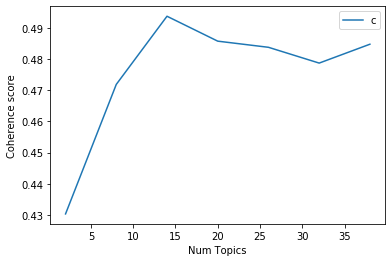

In [38]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values
#first ask then run
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)
# 
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [65]:
lda_model.print_topics(20,num_words=15)[:10]

[(0,
  '0.039*"bus" + 0.024*"official" + 0.020*"student" + 0.016*"passenger" + 0.013*"college" + 0.012*"airport" + 0.011*"private" + 0.011*"pass" + 0.010*"bmtc" + 0.009*"security" + 0.008*"travel" + 0.008*"service" + 0.006*"india" + 0.006*"senior" + 0.006*"bengaluru"'),
 (1,
  '0.039*"government" + 0.036*"project" + 0.024*"station" + 0.020*"work" + 0.015*"railway" + 0.015*"rs_crore" + 0.013*"year" + 0.012*"metro" + 0.012*"state" + 0.011*"official" + 0.011*"cost" + 0.011*"public" + 0.010*"complete" + 0.010*"train" + 0.009*"build"'),
 (2,
  '0.028*"tree" + 0.019*"department" + 0.018*"park" + 0.017*"city" + 0.016*"bengaluru" + 0.014*"day" + 0.011*"plant" + 0.007*"citizen" + 0.007*"toilet" + 0.007*"people" + 0.007*"add" + 0.007*"year" + 0.007*"director" + 0.007*"animal" + 0.006*"include"'),
 (3,
  '0.069*"bbmp" + 0.025*"court" + 0.023*"resident" + 0.022*"city" + 0.019*"waste" + 0.018*"garbage" + 0.012*"civic_body" + 0.011*"issue" + 0.010*"area" + 0.009*"ward" + 0.009*"chief" + 0.008*"colle

In [79]:
x = lda_model.get_document_topics(corpus[0])
x
# t = 0
# ans = 0
# for i in x:
#     if t < i[1]:
#         t=i[1]
#         ans=i[0]
# ans

[(0, 0.043917463760853835),
 (1, 0.053765717806604656),
 (2, 0.050231149190693075),
 (3, 0.08762321237792726),
 (4, 0.03719567139311815),
 (5, 0.0425732437220054),
 (6, 0.03913320352076573),
 (7, 0.06178324913251894),
 (8, 0.0415024956002489),
 (9, 0.084609767774215),
 (10, 0.30787262791174796),
 (11, 0.044450132462444204),
 (12, 0.10534206534685696)]

In [75]:
def tags(corp):
    x = lda_model.get_document_topics(corp)
    ans = []
    for i in x:
        if i[1] >=0.05:
            ans.append(i[0])
    return ans

In [76]:
df['cluster'] = [tags(corp) for corp in corpus]

In [77]:
df['cluster']

0                    [1, 2, 3, 7, 9, 10, 12]
1                       [0, 4, 6, 8, 10, 12]
2                       [1, 3, 4, 9, 11, 12]
3                         [0, 1, 5, 6, 7, 9]
4                           [2, 3, 8, 9, 12]
5                               [1, 5, 6, 7]
6                  [1, 2, 3, 5, 6, 7, 9, 11]
7                                 [2, 6, 11]
8                           [0, 2, 6, 7, 11]
9       [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12]
10                    [0, 1, 3, 5, 7, 9, 12]
11                             [5, 6, 7, 10]
12                          [5, 7, 8, 9, 12]
13                          [0, 2, 5, 7, 12]
14                                 [5, 7, 9]
15                             [0, 6, 8, 10]
16                       [2, 4, 5, 6, 7, 10]
17                             [3, 5, 7, 11]
18                                    [3, 9]
19                             [0, 2, 9, 12]
20                          [4, 5, 6, 7, 11]
21              [1, 2, 3, 4, 5, 7, 8, 9, 11]
22        

In [78]:
df.head()


title  \
0  IMA founder has at least 14 properties worth 5...   
1  Man who invested Rs 9L in IMA dies of heart at...   
2            BBMP, cops to meet over seized vehicles   
3              More women opt for MBA course at IIMB   
4  Citizens suffer as fallen trees, branches lie ...   

                                                text  \
0  mohammed mansoor khan the elusive managing dir...   
1  a year old man who had invested in the ima gro...   
2  mayor gangambike mallikarjun on thursday inspe...   
3  the indian institute of management bangalore i...   
4  trees and branches that were brought down by r...   

                                              tag          date  \
0                                      IMA fraud,   Jun 14 2019   
1                            IMA fraud,Chit fund,   Jun 14 2019   
2                           seized vehicles,BBMP,   Jun 14 2019   
3  Bengaluru,Indian Institute of Management,IIMB,   Jun 13 2019   
4             monsoon,BBMP,Rain damage,Benglauru,   Jun 13 2019   

                   cluster  
0  [1, 2, 3, 7, 9, 10, 12]  
1     [0, 4, 6, 8, 10, 12]  
2     [1, 3, 4, 9, 11, 12]  
3       [0, 1, 5, 6, 7, 9]  
4         [2, 3, 8, 9, 12]

In [ ]:
df['cluster'].value_counts()

In [81]:
cluster_count =[]

In [83]:
df['date'].value_counts()

 Jun 13 2019    46
 Jun 09 2019    34
 Feb 06 2019    32
 Jun 14 2019    28
 Mar 20 2019    26
 Dec 04 2018    26
 Oct 10 2018    26
 Apr 13 2019    26
 Feb 04 2019    26
 Jun 08 2019    26
 Mar 28 2019    24
 Sep 30 2018    24
 Jan 28 2019    24
 Mar 19 2019    22
 Mar 07 2019    22
 Jan 21 2019    22
 Mar 24 2019    22
 Mar 26 2019    22
 Mar 16 2019    20
 Jun 11 2019    20
 Jun 12 2019    20
 Mar 14 2019    20
 Mar 17 2019    20
 Apr 17 2019    20
 Oct 02 2018    20
 Mar 04 2019    20
 Jan 31 2019    20
 Jan 22 2019    18
 May 02 2019    18
 Jan 23 2019    18
                ..
 Feb 21 2019     2
 Oct 27 2018     2
 Sep 06 2018     2
 Jan 16 2019     2
 May 09 2019     2
 Jan 29 2019     2
 Oct 23 2018     2
 Feb 16 2019     2
 Dec 19 2018     2
 Nov 15 2018     2
 Feb 20 2019     2
 May 10 2019     2
 Nov 23 2018     2
 Feb 15 2019     2
 Nov 06 2018     2
 Mar 01 2019     2
 May 31 2019     2
 Feb 05 2019     2
 Oct 15 2018     2
 Oct 29 2018     2
 Apr 06 2019     2
 May 28 2019

In [91]:
month_count =np.zeros((11,13))
month_count

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [92]:
for i in df.index:
    if df['date'][i][-4:] == '2018':   
        if df['date'][i][:4].strip()=='Aug':
            for j in df['cluster'][i]:
                month_count[0][j]+=1
                
        elif df['date'][i][:4].strip()=='Sep':
            for j in df['cluster'][i]:
                month_count[1][j]+=1
                
        elif df['date'][i][:4].strip()=='Oct':
            for j in df['cluster'][i]:
                month_count[2][j]+=1
                
        elif df['date'][i][:4].strip()=='Nov':
            for j in df['cluster'][i]:
                month_count[3][j]+=1
                
        elif df['date'][i][:4].strip()=='Dec':
            for j in df['cluster'][i]:
                month_count[4][j]+=1
        
    else:
        if df['date'][i][:4].strip()=='Jun':
            for j in df['cluster'][i]:
                month_count[10][j]+=1
                
        elif df['date'][i][:4].strip()=='May':
            for j in df['cluster'][i]:
                month_count[9][j]+=1
                
        elif df['date'][i][:4].strip()=='Apr':
            for j in df['cluster'][i]:
                month_count[8][j]+=1
        
        elif df['date'][i][:4].strip()=='Mar':
            for j in df['cluster'][i]:
                month_count[7][j]+=1
        
        elif df['date'][i][:4].strip()=='Feb':
            for j in df['cluster'][i]:
                month_count[6][j]+=1
        
        elif df['date'][i][:4].strip()=='Jan':
            for j in df['cluster'][i]:
                month_count[5][j]+=1


In [93]:
month_count

array([[ 22.,  44.,  16.,  48.,   4.,  26.,  20.,  22.,  12.,  48.,   8.,
         36.,  34.],
       [ 44.,  94.,  54., 106.,  22.,  44.,  56.,  42.,  32., 110.,  30.,
        100.,  78.],
       [ 68.,  86.,  62.,  80.,  42.,  86.,  72.,  84.,  52.,  86.,  34.,
         84.,  74.],
       [ 40.,  56.,  44.,  68.,  26.,  48.,  46.,  52.,  22.,  62.,  20.,
         58.,  50.],
       [ 62.,  84.,  52.,  88.,  44.,  72.,  58.,  72.,  56., 100.,  40.,
         90.,  84.],
       [ 86., 100.,  84.,  88., 100.,  68.,  70.,  70., 100.,  94., 104.,
        106.,  86.],
       [ 72.,  66.,  46.,  42.,  60.,  62.,  44.,  64.,  64.,  40.,  54.,
         68.,  54.],
       [136., 168., 150., 134., 226., 116., 124., 162., 214., 176., 204.,
        160., 184.],
       [112.,  54.,  62.,  60., 128.,  72.,  74.,  90., 140.,  66.,  86.,
         80.,  86.],
       [ 82.,  62.,  50.,  46., 128.,  54.,  64.,  56., 122.,  90., 106.,
         56.,  78.],
       [ 60.,  74.,  60.,  62.,  94.,  54.,  64., 

In [ ]:
cluster_tags = {'0':'crime_money','1':'crime_kidnaps_arrests_assaults','2':'infra_government_specific','3':'infra_maintainance','4':'crime_murder_suicides','5':'infra_nagarpalika','6':'lifestyle_studentlife','7':'infra_developments','8':'lifestyle_basiceminities','9':'infra_travel','10':'lifestyle_medical','11':'lifestyle_commonpeople','12':'infra_tourists'}

In [ ]:
col =[]
for i in cluster_tags.keys():
    col.append(cluster_tags[i])

In [104]:
col

['crime_money',
 'crime_kidnaps_arrests_assaults',
 'infra_government_specific',
 'infra_maintainance',
 'crime_murder_suicides',
 'infra_nagarpalika',
 'lifestyle_studentlife',
 'infra_developments',
 'lifestyle_basiceminities',
 'infra_travel',
 'lifestyle_medical',
 'lifestyle_commonpeople',
 'infra_tourists']

In [101]:
db = pd.DataFrame(month_count, columns=col)

In [102]:
db.head()

crime_money  crime_kidnaps_arrests_assaults  infra_government_specific  \
0         22.0                            44.0                       16.0   
1         44.0                            94.0                       54.0   
2         68.0                            86.0                       62.0   
3         40.0                            56.0                       44.0   
4         62.0                            84.0                       52.0   

   infra_maintainance  crime_murder_suicides  infra_nagarpalika  \
0                48.0                    4.0               26.0   
1               106.0                   22.0               44.0   
2                80.0                   42.0               86.0   
3                68.0                   26.0               48.0   
4                88.0                   44.0               72.0   

   lifestyle_studentlife  infra_developments  lifestyle_basiceminities  \
0                   20.0                22.0                      12.0   
1                   56.0                42.0                      32.0   
2                   72.0                84.0                      52.0   
3                   46.0                52.0                      22.0   
4                   58.0                72.0                      56.0   

   infra_travel  lifestyle_medical  lifestyle_commonpeople  infra_tourists  
0          48.0                8.0                    36.0            34.0  
1         110.0               30.0                   100.0            78.0  
2          86.0               34.0                    84.0            74.0  
3          62.0               20.0                    58.0            50.0  
4         100.0               40.0                    90.0            84.0

In [103]:
db.to_csv("monthsd.csv",index=False)